## 5. GLMの尤度比検定の非対称性

In [2]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import polars as pl

/home/yoshino/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
df = pl.read_csv('./data/chapter3/data3a.csv')
f2id = {'C': 0, 'T': 1}

# メモリの節約(今回はデータ数が少ないのでする必要はないけど、good practiceとして)
df = df.with_columns(
  [
    pl.col('y').cast(pl.datatypes.Int16),
    pl.col('x').cast(pl.datatypes.Float32),
    pl.col('f').apply(lambda x: f2id[x]).alias('f2').cast(pl.datatypes.Int8)
  ]
)
df.head()

y,x,f,f2
i16,f32,str,i8
6,8.31,"""C""",0
6,9.44,"""C""",0
6,9.5,"""C""",0
12,9.07,"""C""",0
10,10.16,"""C""",0


## 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

### xモデル

In [10]:
x_model = smf.glm(formula='y ~ x', data=df, family=sm.families.Poisson())
x_model = x_model.fit()
x_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Wed, 18 Jan 2023   Deviance:                       84.993
Time:                        19:05:33   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

### 一定モデル

In [11]:
null_model = smf.glm(formula='y ~ 1', data=df, family=sm.families.Poisson())
null_model = null_model.fit()
null_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Wed, 18 Jan 2023   Deviance:                       89.507
Time:                        19:06:11   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):         -1.776e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0580      0.036     57.586      0.000       1.988       2.128
==============================================================================
"""

### ２つのモデルの差

In [16]:
# 4.5より小さいのが正常であるならば、x_modelの方が対数尤度は大きいのでx_modelを採用する
-2 * (null_model.llf - x_model.llf) 

4.513940040016962

### ブートストラップ法

In [18]:
mu = np.exp(null_model.params)
print('mu: ', mu)

mu:  Intercept    7.83
dtype: float64


In [21]:
x = np.random.sample(50)
x

array([0.83412674, 0.11005716, 0.18143033, 0.24037708, 0.69881429,
       0.32368956, 0.77130111, 0.51653818, 0.43359261, 0.86526647,
       0.3742654 , 0.35679346, 0.87625439, 0.99127638, 0.58585746,
       0.80164943, 0.0475307 , 0.60868344, 0.65571133, 0.46458793,
       0.89221754, 0.1952634 , 0.05613101, 0.59482799, 0.73597981,
       0.5104811 , 0.55580208, 0.53890341, 0.35492894, 0.85557048,
       0.31888059, 0.56469932, 0.5008184 , 0.23255719, 0.07007972,
       0.36933843, 0.97138281, 0.94867843, 0.43443496, 0.33561647,
       0.73345208, 0.8588252 , 0.04156282, 0.18248049, 0.54320546,
       0.37478676, 0.71710832, 0.52246476, 0.68545834, 0.43028373])

In [24]:
y = np.random.poisson(mu, 50)  # 一定モデルで推測した平均を利用してポアソン分布を生成(一定モデルを正しいと仮定)
x = np.random.sample(50)       # yと関連のない値
data = pl.DataFrame(data={'x': x, 'y': y})
data.head()

x,y
f64,i64
0.073952,7
0.289799,6
0.887913,3
0.374825,8
0.766326,7


In [26]:
x_model_tmp = smf.glm(formula='y ~ x', data=data, family=sm.families.Poisson())
x_model_tmp = x_model_tmp.fit()

null_model_tmp = smf.glm(formula='y ~ 1', data=data, family=sm.families.Poisson())
null_model_tmp = null_model_tmp.fit()

diff = -2 * (null_model_tmp.llf - x_model_tmp.llf)
print('diff: ', diff)

diff:  0.30253134015597993


In [27]:
diffs = []
for _ in range(10000):
  y = np.random.poisson(mu, 50) 
  x = np.random.sample(50)   
  data = pl.DataFrame(data={'x': x, 'y': y})


  x_model_tmp = smf.glm(formula='y ~ x', data=data, family=sm.families.Poisson())
  x_model_tmp = x_model_tmp.fit()

  null_model_tmp = smf.glm(formula='y ~ 1', data=data, family=sm.families.Poisson())
  null_model_tmp = null_model_tmp.fit()

  diff = -2 * (null_model_tmp.llf - x_model_tmp.llf)
  diffs.append(diff)

n:  344
P:  0.0344


(array([8.376e+03, 1.169e+03, 3.010e+02, 1.040e+02, 3.300e+01, 1.200e+01,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([1.84877536e-09, 2.00390586e+00, 4.00781172e+00, 6.01171758e+00,
        8.01562344e+00, 1.00195293e+01, 1.20234352e+01, 1.40273410e+01,
        1.60312469e+01, 1.80351527e+01, 2.00390586e+01]),
 <BarContainer object of 10 artists>)

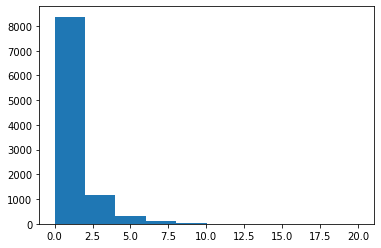

In [30]:
n = sum(1 for d in diffs if d > 4.5) 
print('n: ', n)
print('P: ', (n / 10000)) # 有意水準(0.05)より小さい: 帰無仮説(一定モデル)は棄却: xモデルを採択
plt.hist(diffs)